# Simple seq2seq model in keras that translates english <-> german

As a next step I take the model used for the [toy problem of adding/subtracting numbers](SimpleKerasModelForAddingAndSubstraction.ipynb) and train it with english/german data for machine translation.

As trainings set I use the [European Parliament Proceedings Parallel Corpus 1996-2011](http://statmt.org/europarl/) German-English corpus.

In [1]:
# technical detail so that an instance (maybe running in a different window)
# doesn't take all the GPU memory resulting in some strange error messages
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

/home/janek/.local/share/virtualenvs/rosetta-WKmHhL03/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import math
import matplotlib.pyplot as plt
import os
import tarfile

import keras
import keras.layers as L
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

# Fixing random state ensure reproducible results
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)
tf.set_random_seed(RANDOM_STATE)

In [3]:
START = '^'
END = '\n'

MAX_INPUT_LENGTH = 25
MAX_TARGET_LENGTH = 35
LATENT_DIM = 512
EMBEDDING_DIM = 64
EPOCHS = 20
BATCH_SIZE = 128
DROPOUT = 0.5

## Download and explore data

In [4]:
def download_file(fname, url):
    print(f"Downloading {fname} from {url} ...")
    response = requests.get(url, stream=True)

    total_size = int(response.headers.get('content-length', 0)); 
    block_size = 1024

    download = tqdm(
        response.iter_content(block_size),
        total=math.ceil(total_size // block_size),
        unit='KB',
        unit_scale=True
    )
    with open(f"{fname}", "wb") as handle:
        for data in download:
            handle.write(data)

PATH = 'data'
FILES = {
    'de-en.tgz': 'http://statmt.org/europarl/v7/de-en.tgz',  # incredible: really only http, not https :-o
}
os.makedirs(PATH, exist_ok=True)

for name, url in FILES.items():
    fname = os.path.join(PATH, name)
    exists = os.path.exists(fname)
    size = os.path.getsize(fname) if exists else -1
    if exists and size > 0:
        print(f'{name} already downloaded ({size / 2**20:3.1f} MB)')
        continue
    download_file(fname, url)
    if (fname.endswith(".tgz")):
        tar = tarfile.open(fname, "r:gz")
        tar.extractall(path=PATH)
        tar.close()
        print(f'Extracted {fname} ...')


de-en.tgz already downloaded (188.6 MB)


In [5]:
pd.set_option('max_colwidth', 60)
df = pd.DataFrame(data={
    'input_texts': open(f'{PATH}/europarl-v7.de-en.en', 'r').readlines(),
    'target_texts': open(f'{PATH}/europarl-v7.de-en.de', 'r').readlines(),
})

In [6]:
len(df)
df.target_texts = '^' + df.target_texts  # encode a start symbol (doesn't occur in texts)
df['input_length'] = df.input_texts.apply(len)
df['target_length'] = df.target_texts.apply(len)
df.head()

1920209

,input_texts,target_texts,input_length,target_length
0,Resumption of the session\n,^Wiederaufnahme der Sitzungsperiode\n,26,36
1,I declare resumed the session of the European Parliament...,"^Ich erkläre die am Freitag, dem 17. Dezember unterbroch...",208,220
2,"Although, as you will have seen, the dreaded 'millennium...","^Wie Sie feststellen konnten, ist der gefürchtete ""Mille...",192,187
3,You have requested a debate on this subject in the cours...,^Im Parlament besteht der Wunsch nach einer Aussprache i...,106,112
4,"In the meantime, I should like to observe a minute' s si...",^Heute möchte ich Sie bitten - das ist auch der Wunsch e...,233,219


### Only use short translations right now

So, first I plot sentence length on a logarithmic scale, 
then I only choose short input texts (and a bit longer target texts as german is more verbose than english).

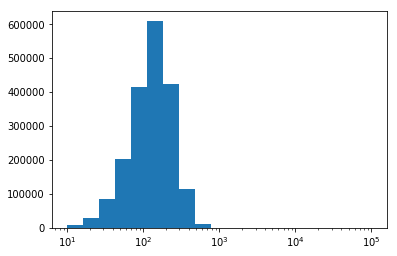

In [7]:
x = df.input_length
logbins = np.logspace(1,5,20)
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.show();

In [8]:
non_empty = (df.input_length > 1) & (df.target_length > 1)  # there are empty phrases like '\n' --> 'Frau Präsidentin\n'
short_inputs = (df.input_length < MAX_INPUT_LENGTH) & (df.target_length < MAX_TARGET_LENGTH)
sum(short_inputs)
df = df[non_empty & short_inputs]

38869

In [9]:
corpus = pd.concat([df.input_texts, df.target_texts])

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=100, filters=None, char_level=True, oov_token='~')
tokenizer.fit_on_texts(corpus)
df['input_sequences'] = tokenizer.texts_to_sequences(df.input_texts)
df['target_sequences'] = tokenizer.texts_to_sequences(df.target_texts)

In [11]:
list(reversed(sorted(tokenizer.word_counts.items(), key=lambda d: d[1])))
sum(1 for w, count in tokenizer.word_counts.items() if count > 1000)

[(' ', 139610),
 ('e', 125420),
 ('s', 84275),
 ('\n', 77738),
 ('i', 73905),
 ('t', 64268),
 ('n', 61648),
 ('a', 59430),
 ('r', 56788),
 ('h', 45028),
 ('.', 42011),
 ('o', 39448),
 ('^', 38869),
 ('l', 38270),
 ('d', 31131),
 ('u', 30441),
 ('c', 28894),
 ('g', 18621),
 ('p', 17190),
 ('\xa0', 16655),
 ('m', 15943),
 ('b', 12933),
 ('f', 11191),
 ('D', 11113),
 ('A', 11021),
 ('T', 10666),
 ('w', 9392),
 ('k', 8609),
 ('!', 8388),
 ('(', 8289),
 (')', 8125),
 ('y', 7334),
 ('W', 7278),
 ('?', 6852),
 ('P', 6599),
 ('ä', 6250),
 ('B', 6080),
 ('H', 5920),
 ('I', 5808),
 ('v', 4337),
 ('S', 4330),
 ('E', 3409),
 ('z', 3206),
 (',', 2831),
 ('V', 2802),
 ('M', 2778),
 ('F', 2361),
 ('N', 2215),
 (':', 2146),
 ('ü', 1857),
 ('-', 1762),
 ('G', 1692),
 ('L', 1687),
 ('R', 1340),
 ('K', 1182),
 ('C', 1171),
 ('O', 1167),
 ('–', 1060),
 ('ö', 992),
 ('Z', 898),
 ('U', 807),
 ('ß', 802),
 ('1', 723),
 ('0', 708),
 ('j', 617),
 ('x', 588),
 ('2', 566),
 ('J', 429),
 ('Y', 344),
 ('q', 341),


58

In [12]:
max_len_input = df.input_length.max()
max_len_target = df.target_length.max()
nr_tokens = len(tokenizer.word_index) + 1  # add 0 padding not in word_index contained

# one hot encoded y_t_output wouldn't fit into memory any longer
# so need to train/validate on batches generated on the fly
def create_batch_generator(samples_ids):
    
    def batch_generator():
        nr_batches = np.ceil(len(samples_ids) / BATCH_SIZE)
        while True:
            shuffled_ids = np.random.permutation(samples_ids)
            batch_splits = np.array_split(shuffled_ids, nr_batches)
            for batch_ids in batch_splits:
                batch_X = pad_sequences(df.iloc[batch_ids].input_sequences, padding='post', maxlen=max_len_input)
                batch_y = pad_sequences(df.iloc[batch_ids].target_sequences, padding='post', maxlen=max_len_target)
                batch_y_t_output = keras.utils.to_categorical(batch_y[:,1:], num_classes=len(tokenizer.word_index)+1)
                batch_x_t_input = batch_y[:,:-1]
                yield ([batch_X, batch_x_t_input], batch_y_t_output)
    
    return batch_generator()

In [13]:
train_ids, val_ids = train_test_split(np.arange(df.shape[0]), test_size=0.1)

In [14]:
nr_tokens
len(tokenizer.word_index)
len(train_ids), len(val_ids)

158

157

In [15]:
encoder_gru = L.Bidirectional(
    L.GRU(LATENT_DIM // 2, dropout=DROPOUT, return_state=True, name='encoder_gru'),
    name='encoder_bidirectional'
)
decoder_gru = L.GRU(LATENT_DIM, dropout=DROPOUT, return_sequences=True, return_state=True, name='decoder_gru')
decoder_dense = L.Dense(nr_tokens, activation='softmax', name='decoder_outputs')

shared_embedding = L.Embedding(nr_tokens, EMBEDDING_DIM, mask_zero=True, name='shared_embedding')

encoder_inputs = L.Input(shape=(max_len_input, ), dtype='int32', name='encoder_inputs')
encoder_embeddings = shared_embedding(encoder_inputs)
_, encoder_state_1, encoder_state_2 = encoder_gru(encoder_embeddings)
encoder_states = L.concatenate([encoder_state_1, encoder_state_2])

decoder_inputs = L.Input(shape=(max_len_target-1, ), dtype='int32', name='decoder_inputs')
decoder_mask = L.Masking(mask_value=0)(decoder_inputs)
decoder_embeddings_inputs = shared_embedding(decoder_mask)
decoder_embeddings_outputs, _ = decoder_gru(decoder_embeddings_inputs, initial_state=encoder_states) 
decoder_outputs = decoder_dense(decoder_embeddings_outputs)


model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

inference_encoder_model = Model(encoder_inputs, encoder_states)
    
inference_decoder_state_inputs = L.Input(shape=(LATENT_DIM, ), dtype='float32', name='inference_decoder_state_inputs')
inference_decoder_embeddings_outputs, inference_decoder_states = decoder_gru(
    decoder_embeddings_inputs, initial_state=inference_decoder_state_inputs
)
inference_decoder_outputs = decoder_dense(inference_decoder_embeddings_outputs)

inference_decoder_model = Model(
    [decoder_inputs, inference_decoder_state_inputs], 
    [inference_decoder_outputs, inference_decoder_states]
)

In [16]:
model.summary()
inference_decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 33)           0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 33)           0           decoder_inputs[0][0]             
__________________________________________________________________________________________________
encoder_inputs (InputLayer)     (None, 24)           0                                            
__________________________________________________________________________________________________
shared_embedding (Embedding)    multiple             10112       encoder_inputs[0][0]             
                                                                 masking_1[0][0]                  
__________

In [17]:
model.compile(optimizer=keras.optimizers.Adam(clipnorm=1.), loss='categorical_crossentropy')

In [18]:
train_generator = create_batch_generator(train_ids)
val_generator = create_batch_generator(val_ids)
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(len(train_ids) / BATCH_SIZE),
    epochs=20,
    validation_data=val_generator,
    validation_steps=np.ceil(len(val_ids) / BATCH_SIZE),
)
#model.fit([X, x_t_input], y_t_output, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
274/274 [==============================] - 20s 71ms/step - loss: 2.0358 - val_loss: 1.1416
Epoch 2/20
274/274 [==============================] - 18s 66ms/step - loss: 1.0139 - val_loss: 0.8499
Epoch 3/20
274/274 [==============================] - 18s 66ms/step - loss: 0.8176 - val_loss: 0.7277
Epoch 4/20
274/274 [==============================] - 19s 68ms/step - loss: 0.7160 - val_loss: 0.6672
Epoch 5/20
274/274 [==============================] - 19s 68ms/step - loss: 0.6490 - val_loss: 0.6228
Epoch 6/20
274/274 [==============================] - 18s 67ms/step - loss: 0.6009 - val_loss: 0.5927
Epoch 7/20
274/274 [==============================] - 19s 69ms/step - loss: 0.5613 - val_loss: 0.5674
Epoch 8/20
274/274 [==============================] - 18s 67ms/step - loss: 0.5291 - val_loss: 0.5516
Epoch 9/20
274/274 [==============================] - 18s 67ms/step - loss: 0.5019 - val_loss: 0.5243
Epoch 10/20
274/274 [==============================] - 19s 69ms/step - loss: 0.479

In [24]:
def decode_sequence(input_seq):
    states_value = inference_encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, max_len_target-1))
    target_seq[0, 0] = tokenizer.word_index[START]
    
    tokens = {idx: token for (token, idx) in tokenizer.word_index.items()}
    
    decoded_sequence = ''
    for i in range(max_len_target):
        output_tokens, output_states = inference_decoder_model.predict(
            [target_seq, states_value]
        )
        
        # greedy search
        sampled_token_idx = np.argmax(output_tokens[0, 0, :])
        sampled_token = tokens.get(sampled_token_idx, '.')
        if sampled_token == END:
            break
        decoded_sequence += sampled_token
            
        target_seq[0, 0] = sampled_token_idx
        states_value = output_states
    
    return decoded_sequence 

In [25]:
def predict(sentence):
    return decode_sequence(keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences([sentence]),
        padding='post',
        maxlen=max_len_input,
    ))

In [26]:
# Performance on some examples:
EXAMPLES = [
    'Hello.',
    'You are welcome.',
    'How do you do?',
    'I hate mondays.',
    'I am a programmer.',
    'Data is the new oil.',
    'It could be worse',
    "I am on top of it",
    "N° Uno",
    "Awesome!",
    "Put your feet up!",
    "From the start till the end!",
    "From dusk till dawn.",
]
for en in [sentence + '\n' for sentence in EXAMPLES]:
    print(f"{en!r} --> {predict(en)!r}")

'Hello.\n' --> 'Hall.'
'You are welcome.\n' --> 'Sie haben vollkommen recht.'
'How do you do?\n' --> 'Wie können wir also tun?'
'I hate mondays.\n' --> 'Ich habe mich geman.'
'I am a programmer.\n' --> 'Ich bit ein Problem.'
'Data is the new oil.\n' --> 'Haute sind nicht nur das.'
'It could be worse\n' --> 'Sie haben der Kommission'
'I am on top of it\n' --> 'Ich bin auch der Meinung'
'N° Uno\n' --> 'Noxin'
'Awesome!\n' --> 'Einverstanden!'
'Put your feet up!\n' --> 'Das ist auch meine Antwort!'
'From the start till the end!\n' --> 'Der Beschäftigung für hinart!'
'From dusk till dawn.\n' --> 'Vor wende auf Ziel.'


In [27]:
# Performance on training set:
for en, de in df[['input_texts', 'target_texts']][:10].values.tolist():
    print(f"Original {en!r}, got {predict(en)!r}, exp: {de[1:]!r}")

Original '\n', got 'Herr Präsident!', exp: 'Frau Präsidentin!\n'
Original 'Agenda\n', got 'Arbeitsplan', exp: 'Arbeitsplan\n'
Original 'Relating to Wednesday:\n', got 'Zum Dienstag:', exp: 'Zum Mittwoch:\n'
Original 'That was the decision.\n', got 'Das war die Frage.', exp: 'Das war der Beschluß.\n'
Original 'We have agreed to this.\n', got 'Das haben wir getan.', exp: 'Wir haben dem zugestimmt.\n'
Original 'It is not a lot to ask.\n', got 'Das ist nicht möglich.', exp: 'Das ist nicht zuviel verlangt.\n'
Original 'Thank you very much.\n', got 'Vielen Dank.', exp: 'Vielen Dank.\n'
Original 'That did not happen.\n', got 'Das geht nicht!', exp: 'Dazu kam es nicht.\n'
Original 'The debate is closed.\n', got 'Die Aussprache ist geschlossen.', exp: 'Die Aussprache ist geschlossen.\n'
Original '\n', got 'Herr Präsident!', exp: 'Herr Präsident!\n'


In [ ]:
df[['input_texts', 'target_texts']][:10]

In [ ]:
# # Mean average error on a test set
# test_df = create_equations_df(size=1000)
# test_df['y_pred'] = test_df.input_texts.apply(predict).astype(int)
# test_df['y_true'] = test_df.result
# print("MAE", np.mean(np.abs(test_df.y_pred - test_df.y_true)))

In [ ]:
## Conclusion

# It doesn't work perfect, but fine enough to show that seq2seq works in some way. I wouldn't be surprised if the mean average error is better than average human bias for calculating without any tools.
# For improvements and further discussions I'll move to a real problem (translating) and main steps will be:
# * Bytepairencoding/Word embeddings
# * Beam Search
# * Attention models